Project path + Imports + Config

In [1]:
# -- Make the project root importable so "from src..." works --
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from src.utils import load_config

# Load config
CFG_PATH = os.path.join(PROJECT_ROOT, "configs", "baseline.yaml")
cfg = load_config(CFG_PATH)

print("Loaded config from", CFG_PATH)
print("Data root:", cfg.data.root)
print("Image ext:", cfg.data.img_ext)
print("Mask ext:", cfg.data.mask_ext)
print("Mask suffix:", cfg.data.get("mask_suffix", ""))

Loaded config from /Users/jonatantobon/Documents/kaggle-sci-image-forgery-seg/configs/baseline.yaml
Data root: data/raw
Image ext: .png
Mask ext: .npy
Mask suffix: 


Define Folders to visualize (Train or Val)

In [2]:
# Choose split: "train" or "val"
SPLIT = "train"

IMG_DIR = os.path.join(PROJECT_ROOT, cfg.data.root, cfg.data[f"{SPLIT}_images_dir"])
MSK_DIR = os.path.join(PROJECT_ROOT, cfg.data.root, cfg.data[f"{SPLIT}_masks_dir"])

IMG_EXT = cfg.data.img_ext
MSK_EXT = cfg.data.mask_ext
MSK_SUFFIX = cfg.data.get("mask_suffix", "")

print("IMG_DIR", IMG_DIR)
print("MSK_DIR", MSK_DIR)
print("IMG_EXT", IMG_EXT, "| MSK_EXT:", MSK_EXT, "| MSK_SUFFIX:", MSK_SUFFIX)

IMG_DIR /Users/jonatantobon/Documents/kaggle-sci-image-forgery-seg/data/raw/train/images
MSK_DIR /Users/jonatantobon/Documents/kaggle-sci-image-forgery-seg/data/raw/train/masks
IMG_EXT .png | MSK_EXT: .npy | MSK_SUFFIX: 


Helpers to load images/masks + overlay

In [3]:
def read_img_rgb(path: str) -> np.ndarray:
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {path}")
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def read_mask(path: str, ext: str) -> np.ndarray:
    ext = ext.lower()
    if ext == ".npy":
        m = np.load(path)
        if m.ndim == 3:
            m = m[..., 0]
        m = m.astype(np.float32)
        m = (m > 0.5).astype(np.uint8)
        return m
    else: 
        m = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if m is None:
            raise FileNotFoundError(f"Could not read mask: {path}")
        return (m > 0).astype(np.uint8)

def overlay_red(img_rgb: np.ndarray, mask01: np.ndarray, alpha: float = 0.5) -> np.ndarray:
    # Mask01 is {0,1}
    ov = img_rgb.copy()
    red = np.zeros_like(img_rgb)
    red[..., 0] = 255 # R channel
    m3 = np.repeat(mask01[..., None].astype(bool), 3, axis=2)
    ov[m3] = (alpha * red[m3] + (1 - alpha) * ov[m3]).astype(np.uint8)
    return ov

Find Valid (image, mask) pairs

In [4]:
img_paths = sorted(glob(os.path.join(IMG_DIR, "*" + IMG_EXT)))
if len(img_paths) == 0:
    raise RuntimeError(f"No images found in {IMG_DIR} with ext {IMG_EXT}")

stems = [os.path.splitext(os.path.basename(p))[0] for p in img_paths]

pairs = []
missing_masks = []
for s in stems:
    mp = os.path.join(MSK_DIR, f"{s}{MSK_SUFFIX}{MSK_EXT}")
    if os.path.exists(mp):
        pairs.append((s, os.path.join(IMG_DIR, s + IMG_EXT), mp))
    else:
        missing_masks.append(mp)

print("Images found:", len(img_paths))
print("Pairs found:", len(pairs))
print("Missing masks (first 5):")
for x in missing_masks[:5]:
    print(" -", x)

if len(pairs) == 0:
    raise RuntimeError("No valid pairs found. Check mask_ext/mask_suffix and filenames.")

Images found: 6
Pairs found: 6
Missing masks (first 5):


Print dataset stats (shapes, dtypes, mask coverage)

In [5]:
def summarize_pairs(stem, ip, mp):
    img = read_img_rgb(ip)
    msk = read_mask(mp, MSK_EXT)

    # Align if needed
    if img.shape[:2] != msk.shape[:2]:
        msk =cv2.resize(msk, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    frac = float(msk.mean()) # Because mask is 0/1
    return {
        "stem": stem, 
        "img_shape": img.shape,
        "img_dtype": str(img.dtype),
        "mask_shape":msk.shape,
        "mask_dtype": str(msk.dtype),
        "mask_fg_frac": frac,
    }

for stem, ip, mp in pairs[:10]:
    info = summarize_pairs(stem, ip, mp)
    print(info)

{'stem': '10', 'img_shape': (512, 648, 3), 'img_dtype': 'uint8', 'mask_shape': (512, 648), 'mask_dtype': 'uint8', 'mask_fg_frac': 0.0}
{'stem': '156', 'img_shape': (1200, 1600, 3), 'img_dtype': 'uint8', 'mask_shape': (1200, 1600), 'mask_dtype': 'uint8', 'mask_fg_frac': 0.0}
{'stem': '176', 'img_shape': (85, 517, 3), 'img_dtype': 'uint8', 'mask_shape': (85, 517), 'mask_dtype': 'uint8', 'mask_fg_frac': 0.0}
{'stem': '187', 'img_shape': (877, 802, 3), 'img_dtype': 'uint8', 'mask_shape': (877, 802), 'mask_dtype': 'uint8', 'mask_fg_frac': 0.0}
{'stem': '57', 'img_shape': (256, 320, 3), 'img_dtype': 'uint8', 'mask_shape': (256, 320), 'mask_dtype': 'uint8', 'mask_fg_frac': 0.0}
{'stem': '90', 'img_shape': (1200, 1600, 3), 'img_dtype': 'uint8', 'mask_shape': (1200, 1600), 'mask_dtype': 'uint8', 'mask_fg_frac': 0.0}


Visualize N pairs (image + mask overlay + mask)

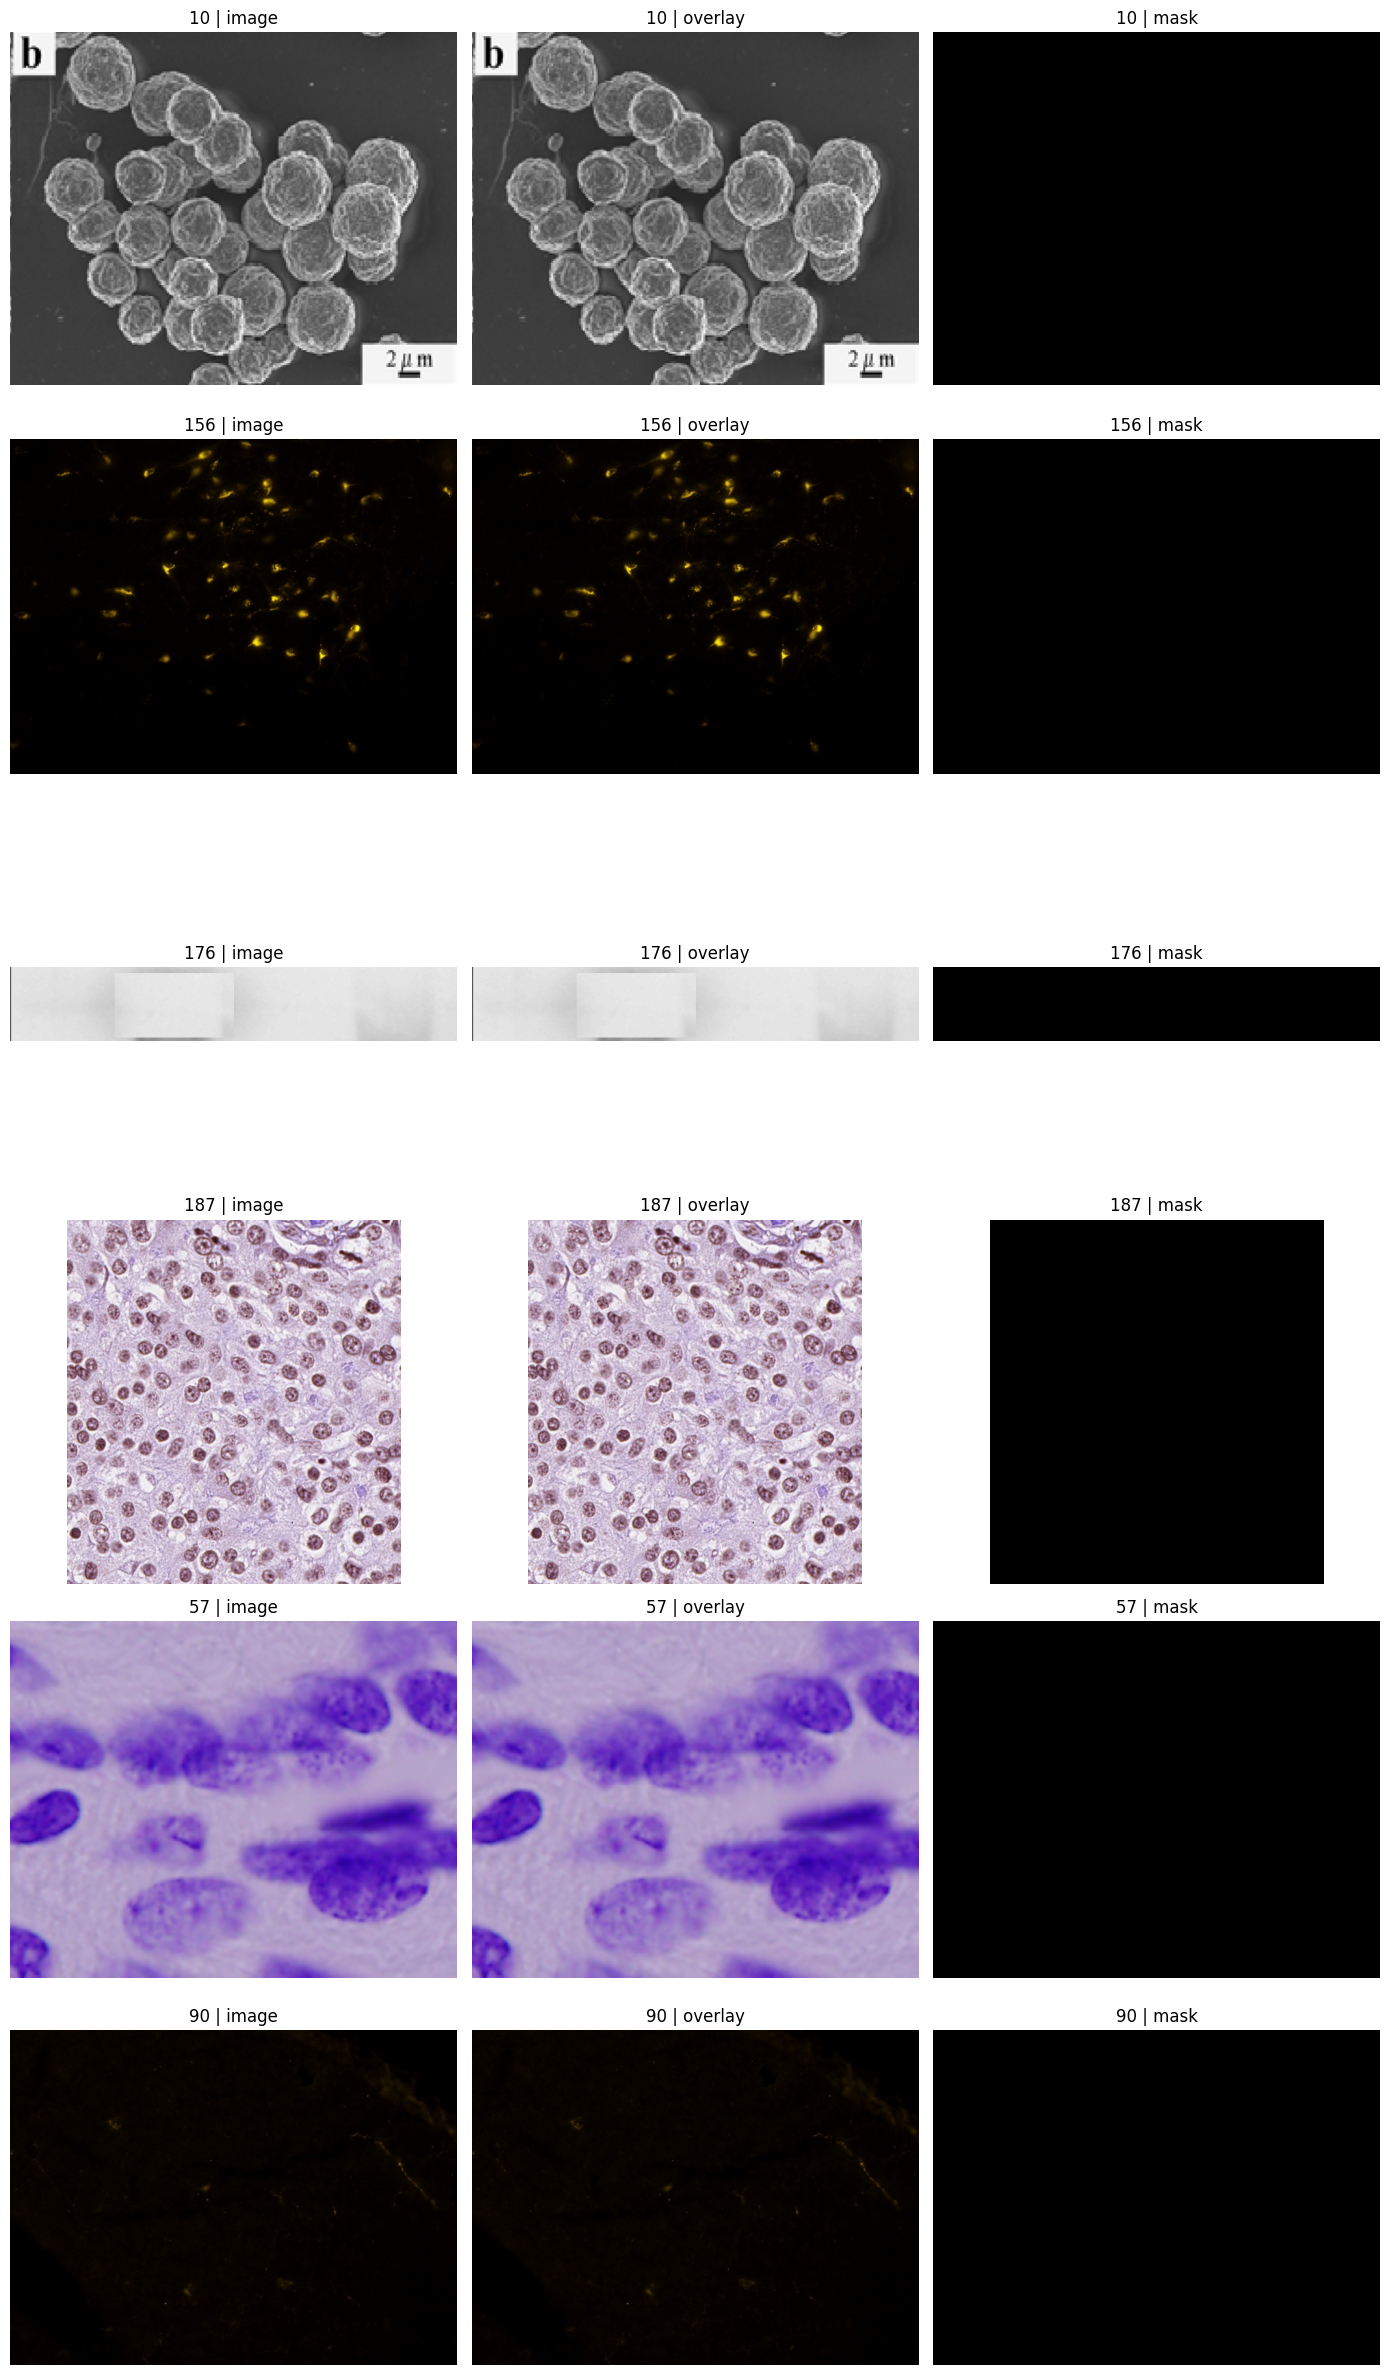

In [6]:
N = min(6, len(pairs))

plt.figure(figsize=(14, 4 * N))
for i, (stem, ip, mp) in enumerate(pairs[:N]):
    img = read_img_rgb(ip)
    msk = read_mask(mp, MSK_EXT)

    if img.shape[:2] != msk.shape[:2]:
        msk = cv2.resize(msk, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    ov = overlay_red(img, msk, alpha=0.5)

    # Image
    plt.subplot(N, 3, i*3 + 1)
    plt.imshow(img)
    plt.title(f"{stem} | image")
    plt.axis("off")

    # Overlay
    plt.subplot(N, 3, i*3 + 2)
    plt.imshow(ov)
    plt.title(f"{stem} | overlay")
    plt.axis("off")

    # Mask
    plt.subplot(N, 3, i*3 + 3)
    plt.imshow(msk, cmap="gray")
    plt.title(f"{stem} | mask")
    plt.axis("off")

plt.tight_layout()
plt.show()